<a href="https://colab.research.google.com/github/TrevBot17/MADS-591/blob/main/tmccalmo_akleber_Milestone_I_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Human Happiness vs. Life Expectancy**

> Project for MILESTONE 1, SIADS 591 & 592 <br>
> Projet Team: Trevor McCalmont & Andre Kleber


## **1. Setup of Environment: Load Kaggle Datasets into Google Colab**

https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

In [1]:
# Install the Kaggle library
# ! pip install kaggle

Download the files from Kaggle

In [2]:
# ! kaggle datasets download kumarajarshi/life-expectancy-who

In [3]:
# ! kaggle datasets download unsdsn/world-happiness

In [4]:
# load dataset
from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive
#changing the working directory
%cd /content/gdrive/My Drive/Kaggle

Mounted at /content/gdrive
/content/gdrive/My Drive/Kaggle


## **2. Module imports and load the data**

In [5]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# load happiness data
happ2015 = pd.read_csv("2015.csv")
happ2016 = pd.read_csv("2016.csv")
happ2017 = pd.read_csv("2017.csv")
happ2018 = pd.read_csv("2018.csv")
happ2019 = pd.read_csv("2019.csv")

# load life expectancy data (Kaggle)
life_exp = pd.read_csv("Life Expectancy Data.csv")

# load World Development Indicators dataset
zf = zipfile.ZipFile('WDI_csv.zip') # load zip file
wdi_data = pd.read_csv(zf.open('WDIData.csv')) # from https://datacatalog.worldbank.org/dataset/world-development-indicators

## **3. Data Cleaning**

## 3.1 Cleaning of the Happiness Data



In [7]:
# add column year to each DF
happ2015['Year'] = 2015
happ2016['Year'] = 2016
happ2017['Year'] = 2017
happ2018['Year'] = 2018
happ2019['Year'] = 2019

In [8]:
# rename columns of happ2017 - happ2019 to make them consitent 

happ2017.rename(columns = {'Happiness.Rank': 'Happiness Rank', 'Happiness.Score': 'Happiness Score','Economy..GDP.per.Capita.':'Economy (GDP per Capita)',\
                           'Health..Life.Expectancy.': 'Health (Life Expectancy)', 'Trust..Government.Corruption.': 'Trust (Government Corruption)',\
                           'Dystopia.Residual': 'Dystopia Residual'}, inplace=True)

happ2018.rename(columns = {'Overall rank': 'Happiness Rank', 'Country or region': 'Country', 'Score': 'Happiness Score','GDP per capita':'Economy (GDP per Capita)',\
                           'Healthy life expectancy': 'Health (Life Expectancy)', 'Freedom to make life choices': 'Freedom'}, inplace = True)

happ2019.rename(columns = {'Overall rank': 'Happiness Rank', 'Country or region': 'Country', 'Score': 'Happiness Score','GDP per capita':'Economy (GDP per Capita)',\
                           'Healthy life expectancy': 'Health (Life Expectancy)', 'Freedom to make life choices': 'Freedom'}, inplace = True)

In [9]:
# put all years into one dataframe and drop some columns
df_happ = pd.concat([happ2015, happ2016, happ2017, happ2018, happ2019]).drop(['Standard Error','Dystopia Residual','Lower Confidence Interval','Upper Confidence Interval',\
                                                                    'Whisker.high', 'Whisker.low'], axis=1).reset_index(drop=True)

In [10]:
# check for duplicates and similar spelling for the countries

# pd.set_option('display.max_rows', None) # show all rows

df_happ[~df_happ.duplicated(subset='Country', keep=False)]
df_happ.Country.sort_values().drop_duplicates()
df_happ[df_happ.Country.str.contains('uerto')]

,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Year,Social support,Perceptions of corruption
172,Puerto Rico,Latin America and Caribbean,15,7.039,1.35943,1.08113,0.77758,0.46823,0.12275,0.22202,2016,NaN,NaN


In [11]:
# make countries uniform across all years
df_happ.Country.replace({'North Macedonia': 'Macedonia', 'Hong Kong S.A.R., China': 'Hong Kong', 'North Cyprus': 'Northern Cyprus',\
                         'Taiwan Province of China': 'Taiwan','Trinidad & Tobago': 'Trinidad and Tobago', 'Somaliland Region': 'Somalia',\
                         'Somaliland region': 'Somalia'}, inplace = True)

In [12]:
df_happ.head()

,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Year,Social support,Perceptions of corruption
0,Switzerland,Western Europe,1,7.587,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2015,NaN,NaN
1,Iceland,Western Europe,2,7.561,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2015,NaN,NaN
2,Denmark,Western Europe,3,7.527,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2015,NaN,NaN
3,Norway,Western Europe,4,7.522,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2015,NaN,NaN
4,Canada,North America,5,7.427,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2015,NaN,NaN


Alternative approach for making the countries uniform: mapping of countries in
column **Country** with countries from the **country_list** library (but not really working):

In [13]:
# pip install country-list

In [14]:
# from country_list import countries_for_language
# # countries_for_language returns a list of tuples now, might be changed to an OrderedDict
# countries = dict(countries_for_language('en'))

# def map_country(x):
#   countries = dict(countries_for_language('en'))
#   for _,i in countries.items():
#     if x.lower() in i.lower():
#       return i
#   return x

# df_happ['Country_map']=df_happ['Country'].apply(map_country)

Function for filling in the missing regions for the years 2017 - 2019

In [15]:
# function for filling in the missing regions for the years 2017 - 2019:

def map_region(row):
  '''
  input: row from dataframe df_happ
  return: Region of the Country
   '''
  # define helper DF for the mapping (only non-NaN entries for Country and Region)
  df_help = df_happ.dropna(subset=['Country','Region']).drop_duplicates(subset=['Country','Region'])

  # condition for the row: if Region value is NaN and the Country is available in the helper DF, then return the Region using the helper DF. Otherwise Region already exist and return it.
  if (pd.isna(row['Region'])) and (row['Country'] in list(df_help.Country)):
    return list(df_help[df_help.Country==row.Country].Region)[0]
  else:
    return row['Region']

df_happ['Region']=df_happ.apply(map_region, axis=1)


In [16]:
# check if still a Region is missing
df_happ[df_happ.Region.isna()]

,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Year,Social support,Perceptions of corruption
745,Gambia,NaN,120,4.516,0.308,NaN,0.428,0.382,NaN,0.269,2019,0.939,0.167


In [17]:
# set Region for Gambia to Sub-Saharan Africa
df_happ.loc[745,'Region']='Sub-Saharan Africa'

In [18]:
df_happ.loc[745:746]

,Country,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Year,Social support,Perceptions of corruption
745,Gambia,Sub-Saharan Africa,120,4.516,0.308,NaN,0.428,0.382,NaN,0.269,2019,0.939,0.167
746,Kenya,Sub-Saharan Africa,121,4.509,0.512,NaN,0.581,0.431,NaN,0.372,2019,0.983,0.053


In [19]:
df_happ.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 782 entries, 0 to 781
Data columns (total 13 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Country                        782 non-null    object 
 1   Region                         782 non-null    object 
 2   Happiness Rank                 782 non-null    int64  
 3   Happiness Score                782 non-null    float64
 4   Economy (GDP per Capita)       782 non-null    float64
 5   Family                         470 non-null    float64
 6   Health (Life Expectancy)       782 non-null    float64
 7   Freedom                        782 non-null    float64
 8   Trust (Government Corruption)  470 non-null    float64
 9   Generosity                     782 non-null    float64
 10  Year                           782 non-null    int64  
 11  Social support                 312 non-null    float64
 12  Perceptions of corruption      311 non-null    flo

In [20]:
# change order of column and sort alphabetically by country and year
col_order = ['Country', 'Year', 'Region', 'Happiness Rank', 'Happiness Score',
       'Economy (GDP per Capita)', 'Family', 'Health (Life Expectancy)',
       'Freedom', 'Trust (Government Corruption)', 'Generosity',
       'Social support', 'Perceptions of corruption']
df_happ = df_happ[col_order].sort_values(['Country', 'Year'], ascending = (True, True))

Add ISO country codes to the df_happ dataframe

In [21]:
# load the ISO country codes
df_code=pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv')

# unique countries of df_happ
df_int=pd.DataFrame(df_happ.Country.unique()).rename(columns={0:'Country'})

# merge df_int and df_code
df_country_code=df_int.merge(df_code, how='left', left_on='Country', right_on='COUNTRY')

# check where CODE is missing
# print(df_country_code[df_country_code.CODE.isna()]) # <- comment out to get printed
# create dictionary with the ISO Codes where the CODE is missing 
dict_code={'Congo (Brazzaville)': 'COG', 'Congo (Kinshasa)': 'COD',  'Gambia': 'GMB', 'Ivory Coast': 'CIV', 'Myanmar': 'MMR', 'South Korea': 'KOR'}

# fill in the missing CODES, and show only column Country and CODE
df_country_code['CODE'] = df_country_code['CODE'].fillna(df_country_code['Country'].apply(lambda x: dict_code.get(x)))
df_country_code = df_country_code[['Country','CODE']]

# add Country Code to df_happ by merging df_happ and df_country_code -> df_happ_cc
df_happ_cc = df_happ.merge(df_country_code, on='Country')
code_col = df_happ_cc.pop('CODE')
df_happ_cc.insert(1, 'Country Code', code_col)

In [22]:
df_happ_cc.head(20)

,Country,Country Code,Year,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Social support,Perceptions of corruption
0,Afghanistan,AFG,2015,Southern Asia,153,3.575,0.319820,0.302850,0.303350,0.234140,0.097190,0.365100,NaN,NaN
1,Afghanistan,AFG,2016,Southern Asia,154,3.360,0.382270,0.110370,0.173440,0.164300,0.071120,0.312680,NaN,NaN
2,Afghanistan,AFG,2017,Southern Asia,141,3.794,0.401477,0.581543,0.180747,0.106180,0.061158,0.311871,NaN,NaN
3,Afghanistan,AFG,2018,Southern Asia,145,3.632,0.332000,NaN,0.255000,0.085000,NaN,0.191000,0.537,0.036
4,Afghanistan,AFG,2019,Southern Asia,154,3.203,0.350000,NaN,0.361000,0.000000,NaN,0.158000,0.517,0.025
5,Albania,ALB,2015,Central and Eastern Europe,95,4.959,0.878670,0.804340,0.813250,0.357330,0.064130,0.142720,NaN,NaN
6,Albania,ALB,2016,Central and Eastern Europe,109,4.655,0.955300,0.501630,0.730070,0.318660,0.053010,0.168400,NaN,NaN
7,Albania,ALB,2017,Central and Eastern Europe,109,4.644,0.996193,0.803685,0.731160,0.381499,0.039864,0.201313,NaN,NaN
8,Albania,ALB,2018,Central and Eastern Europe,112,4.586,0.916000,NaN,0.790000,0.419000,NaN,0.149000,0.817,0.032
9,Albania,ALB,2019,Central and Eastern Europe,107,4.719,0.947000,NaN,0.874000,0.383000,NaN,0.178000,0.848,0.027


## 3.2 Cleaning of the Life Expectancy Data


In [23]:
# get columns/variables of interest from the wdi_data. This part has to be done manually by checking the column 'Indicator Name' of the wdi_data df

# get all the variables with the respective code 
indicators = wdi_data[['Indicator Name', 'Indicator Code']].drop_duplicates()

# search for the variables, e.g. 'Life expectancy':
indicators[indicators['Indicator Name'].str.contains('Life expectancy')]
# indicators[indicators['Indicator Code']=='SP.DYN.LE00.IN']#.iloc[0][0]

,Indicator Name,Indicator Code
694,"Life expectancy at birth, female (years)",SP.DYN.LE00.FE.IN
695,"Life expectancy at birth, male (years)",SP.DYN.LE00.MA.IN
696,"Life expectancy at birth, total (years)",SP.DYN.LE00.IN


In [24]:
# dictionary for the variables of interest

dict_map_indi = {'SP.DYN.LE00.IN': 'Life expectancy at birth, total (years)', 'SH.STA.SUIC.P5': 'Suicide mortality rate (per 100,000 population)', 'SH.ALC.PCAP.LI': 'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)',\
                 'SH.XPD.CHEX.GD.ZS': 'Current health expenditure (% of GDP)', 'SP.DYN.IMRT.IN': 'Mortality rate, infant (per 1,000 live births)', 'SH.HIV.INCD.TL.P3': 'Incidence of HIV, all (per 1,000 uninfected population)', \
                 'NY.GDP.PCAP.CD': 'GDP per capita (current US$)', 'SP.POP.TOTL': 'Population, total', 'SE.XPD.TOTL.GD.ZS': 'Government expenditure on education, total (% of GDP)'}
# pd.DataFrame({'Indicator Name': dict_map_indi.values(), 'Indicator Code': dict_map_indi.keys()})

Create Life Expectancy DF from wdi_data dataset

In [25]:
# function to create the life expectancy DF from the World Development Indicators dataset wdi_data for the years 2015 - 2019

def life_ext_DF(df, col_of_interest):
  '''
  input: df & list of columns of interest from the World Development Indicators dataset from https://datacatalog.worldbank.org/
  output: df with variable of interest as columns from 2015-2019
  '''
  # loop the columns of interest
  for col in col_of_interest:
    # create helper df only with Indicator Code for the respective iteration
    df_help = df[df["Indicator Code"] == col]

    # set variable value_name (used below in pd.melt function)
    value_name = df_help.iloc[0]['Indicator Name']

    # create columns for the new df: Country Code, Country Name , 2015 - 2019
    col_melt = [str(x) for x in range(2015,2020)]
    col_melt.insert(0,'Country Code')
    col_melt.insert(1,'Country Name')
    if col == col_of_interest[0]: # first iteration will create new df df_melt
      df_melt = pd.melt(df_help[col_melt], id_vars=['Country Code','Country Name'],var_name='Year', value_name=value_name)
    else: # next ierations will add new column to df_melt
      df_melt[value_name] =  pd.melt(df_help[col_melt], id_vars=['Country Code','Country Name'],var_name='Year', value_name=value_name)[value_name]
    df_melt.Year = df_melt.Year.astype(int)

  return df_melt

In [26]:
# create life expectancy df
col_of_interest = list(dict_map_indi.keys())
life_exp = life_ext_DF(wdi_data, col_of_interest)
life_exp[(life_exp['Country Code']=='DEU')]

,Country Code,Country Name,Year,"Life expectancy at birth, total (years)","Suicide mortality rate (per 100,000 population)","Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)",Current health expenditure (% of GDP),"Mortality rate, infant (per 1,000 live births)","Incidence of HIV, all (per 1,000 uninfected population)",GDP per capita (current US$),"Population, total","Government expenditure on education, total (% of GDP)"
122,DEU,Germany,2015,80.641463,13.3,13.06,11.178020,3.3,NaN,41086.729674,81686611.0,4.83498
388,DEU,Germany,2016,80.990244,13.0,NaN,11.230436,3.3,NaN,42107.517270,82348669.0,4.84022
654,DEU,Germany,2017,80.992683,12.6,NaN,11.322296,3.3,NaN,44442.771840,82657002.0,4.90512
920,DEU,Germany,2018,80.892683,12.9,12.91,11.429951,3.3,NaN,47787.160507,82905782.0,NaN
1186,DEU,Germany,2019,80.941463,12.3,NaN,NaN,3.2,NaN,46467.516202,83092962.0,NaN


## 3.3 Merging Happiness Data and Life Expectancy Data

In [27]:
life_exp.sort_values(by = ['Country Name', 'Year'], inplace = True) 
df_happ_cc.sort_values(by = ['Country', 'Year'], inplace = True)
df_total = df_happ_cc.merge(life_exp, on = ['Country Code','Year'])
df_total.isna().sum()


Country                                                                                                   0
Country Code                                                                                              0
Year                                                                                                      0
Region                                                                                                    0
Happiness Rank                                                                                            0
Happiness Score                                                                                           0
Economy (GDP per Capita)                                                                                  0
Family                                                                                                  304
Health (Life Expectancy)                                                                                  0
Freedom                     

In [28]:
# filling NaN values with column means per Country 

def func(group):
  '''
  input: group object
  return: transformed group object
  '''
  # use fillna with mean per group to replace NaNs
  group = group.sort_values('Year').fillna(group.mean())
  return group

df_final = df_total.groupby('Country Code').apply(func).reset_index(drop=True)

In [29]:
df_final.isna().sum()

Country                                                                                                   0
Country Code                                                                                              0
Year                                                                                                      0
Region                                                                                                    0
Happiness Rank                                                                                            0
Happiness Score                                                                                           0
Economy (GDP per Capita)                                                                                  0
Family                                                                                                    1
Health (Life Expectancy)                                                                                  0
Freedom                     

## **4. Correlation Analysis**

In [30]:
# function for correlation analysis for a given year

def corr(df, year):
  return df.groupby('Year').corr().loc[year,:]

df_corr_year = corr(df_final, 2018)
# df_corr_year

In [31]:
df_corr_year.columns

Index(['Happiness Rank', 'Happiness Score', 'Economy (GDP per Capita)',
       'Family', 'Health (Life Expectancy)', 'Freedom',
       'Trust (Government Corruption)', 'Generosity', 'Social support',
       'Perceptions of corruption', 'Life expectancy at birth, total (years)',
       'Suicide mortality rate (per 100,000 population)',
       'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)',
       'Current health expenditure (% of GDP)',
       'Mortality rate, infant (per 1,000 live births)',
       'Incidence of HIV, all (per 1,000 uninfected population)',
       'GDP per capita (current US$)', 'Population, total',
       'Government expenditure on education, total (% of GDP)'],
      dtype='object')

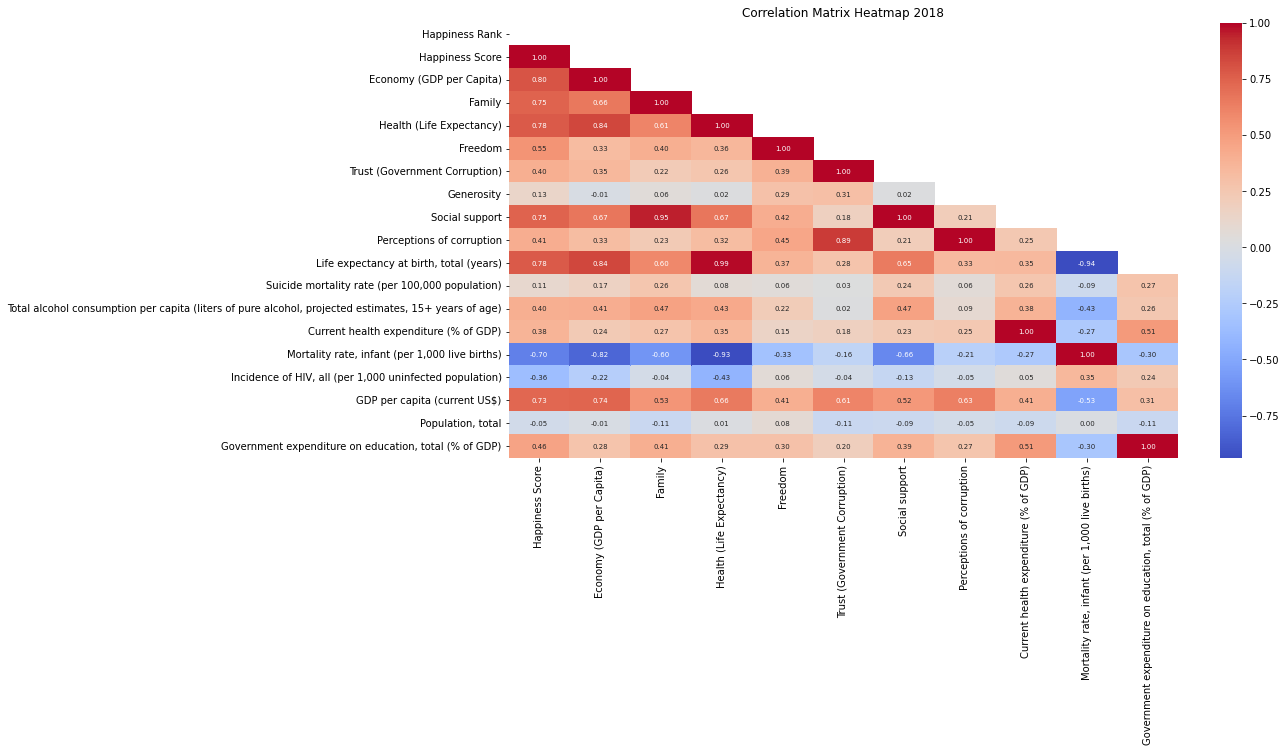

In [32]:
cols = ['Happiness Score', 'Economy (GDP per Capita)', 'Family',
        'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
        'Social support', 'Perceptions of corruption',
        'Current health expenditure (% of GDP)', 'Mortality rate, infant (per 1,000 live births)',
        'Government expenditure on education, total (% of GDP)']
mask = np.triu(df_corr_year[cols])
plt.figure(figsize=(15,8))
sns.heatmap(df_corr_year[cols], annot=True, annot_kws={"fontsize":7}, fmt='.2f', cmap='coolwarm', mask=mask)
# sns.heatmap(df_happ_cc[cols], annot=True, annot_kws={"fontsize":7}, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix Heatmap 2018')
plt.show()

In [33]:
df_final.columns

Index(['Country', 'Country Code', 'Year', 'Region', 'Happiness Rank',
       'Happiness Score', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Social support', 'Perceptions of corruption',
       'Country Name', 'Life expectancy at birth, total (years)',
       'Suicide mortality rate (per 100,000 population)',
       'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)',
       'Current health expenditure (% of GDP)',
       'Mortality rate, infant (per 1,000 live births)',
       'Incidence of HIV, all (per 1,000 uninfected population)',
       'GDP per capita (current US$)', 'Population, total',
       'Government expenditure on education, total (% of GDP)'],
      dtype='object')

In [34]:
cols = ['Happiness Score', 'Life expectancy at birth, total (years)',
       'Suicide mortality rate (per 100,000 population)',
       'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)',
       'Current health expenditure (% of GDP)',
       'Mortality rate, infant (per 1,000 live births)',
       'Incidence of HIV, all (per 1,000 uninfected population)',
       'GDP per capita (current US$)', 'Population, total',
       'Government expenditure on education, total (% of GDP)']

In [35]:
len(cols)

10

In [36]:
corr_df = df_final[cols].corr()
mask_ut = np.tril(np.ones(corr_df.shape)).astype(np.bool)
# mask_ut[0:len(cols),0:len(cols)]

In [37]:
corr_df.shape

(10, 10)

In [38]:
corr_df.columns = ['Happiness Score', 'Life Expectancy', 'Suicide Rate', 'Alcohol Consumption',
                   'Health Expenditure', 'Infant Mortality Rate', 'Incidence of HIV',
                   'GDP Per Capita', 'Population', 'Education Expenditure']
corr_df.index = ['Happiness Score', 'Life Expectancy', 'Suicide Rate', 'Alcohol Consumption',
                   'Health Expenditure', 'Infant Mortality Rate', 'Incidence of HIV',
                   'GDP Per Capita', 'Population', 'Education Expenditure']

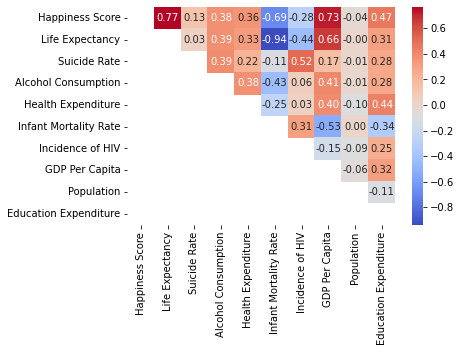

In [39]:
sns.heatmap(corr_df, annot = True, annot_kws={"fontsize":10}, fmt='.2f', cmap='coolwarm', mask = mask_ut)

## **5. Visualizations**

## 5.1 Line Chart Happiness Score for all regions from 2015 - 2019

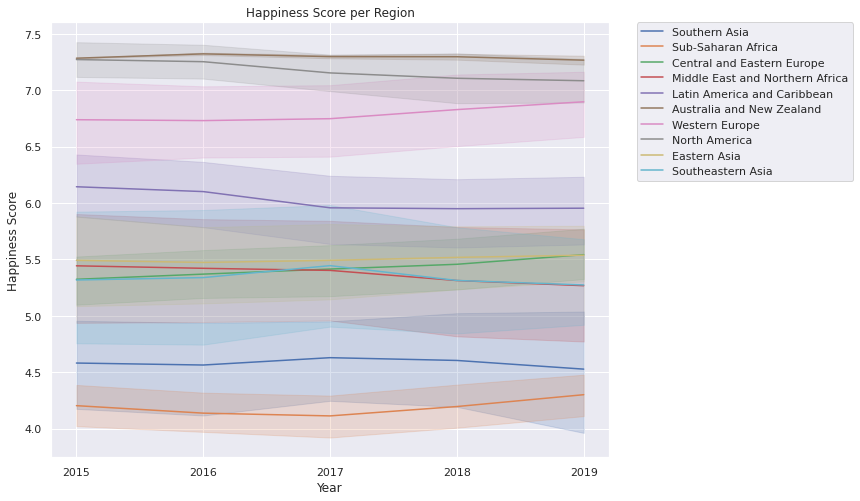

In [40]:
# lineplot for Happiness Score for all regions from 2015 - 2019
sns.set(rc={'figure.figsize':(10,8)})
g = sns.lineplot(x = 'Year', y = 'Happiness Score', hue='Region', data=df_final) 
g.set_xticks([2015, 2016, 2017, 2018, 2019])
g.set_title('Happiness Score per Region')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);


## 5.2 Bar Chart Happiness Score for all regions for 2019

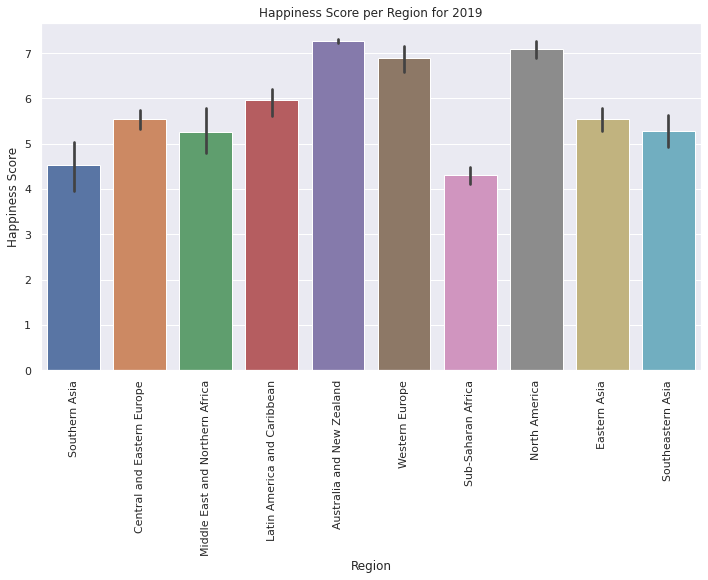

In [41]:
# barplot for Happiness Score for all regions for 2019

sns.barplot(x='Region', y='Happiness Score', data=df_final[df_final.Year==2019])
plt.xticks(rotation=90)
plt.tight_layout()
plt.title('Happiness Score per Region for 2019');

In [42]:
# Happiness Score for all regions for 2019
df_happ_cc[df_happ_cc.Year==2019].sort_values('Happiness Score', ascending=False)
df_happ_cc[df_happ_cc.Year==2019].groupby('Region').mean()['Happiness Score']

Region
Australia and New Zealand          7.267500
Central and Eastern Europe         5.561517
Eastern Asia                       5.688833
Latin America and Caribbean        5.954429
Middle East and Northern Africa    5.237000
North America                      7.085000
Southeastern Asia                  5.273667
Southern Asia                      4.526857
Sub-Saharan Africa                 4.300050
Western Europe                     6.842190
Name: Happiness Score, dtype: float64

## 5.3 Scatter Plot Happiness Score vs.Economy, separated by Region

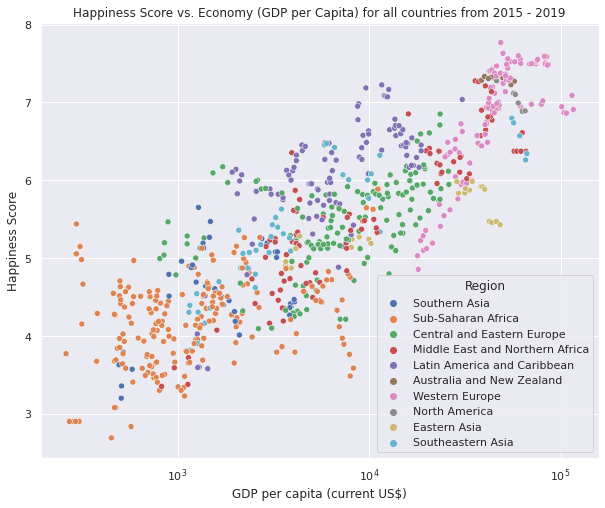

In [43]:
# Scatterplot for Happiness Score vs.Economy, separated by Region

sns.scatterplot(x='GDP per capita (current US$)',y='Happiness Score', hue='Region', data=df_final)
plt.title('Happiness Score vs. Economy (GDP per Capita) for all countries from 2015 - 2019');

#f, ax = plt.subplots(figsize=(8, 8))
plt.gca().set(xscale='log');

In [67]:
# df_final[df_final['Region'] == 'Middle East and Northern Africa'].sort_values('GDP per capita (current US$)', ascending = False).head(20)

## 5.3b Scatter Plot Happiness Score vs. Life Expectancy, separated by Region

In [44]:
df_final.columns

Index(['Country', 'Country Code', 'Year', 'Region', 'Happiness Rank',
       'Happiness Score', 'Economy (GDP per Capita)', 'Family',
       'Health (Life Expectancy)', 'Freedom', 'Trust (Government Corruption)',
       'Generosity', 'Social support', 'Perceptions of corruption',
       'Country Name', 'Life expectancy at birth, total (years)',
       'Suicide mortality rate (per 100,000 population)',
       'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)',
       'Current health expenditure (% of GDP)',
       'Mortality rate, infant (per 1,000 live births)',
       'Incidence of HIV, all (per 1,000 uninfected population)',
       'GDP per capita (current US$)', 'Population, total',
       'Government expenditure on education, total (% of GDP)'],
      dtype='object')

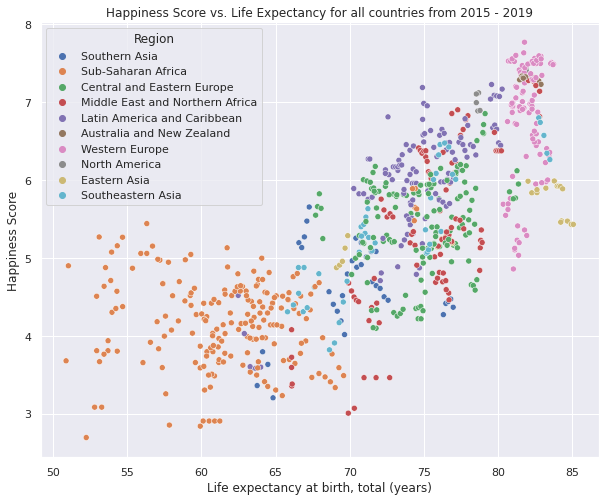

In [45]:
sns.scatterplot(x='Life expectancy at birth, total (years)',y='Happiness Score', hue='Region', data=df_final)
plt.title('Happiness Score vs. Life Expectancy for all countries from 2015 - 2019');

In [46]:
x = df_final[['Life expectancy at birth, total (years)', 'Happiness Score']].corr()
x.index = ['Life Expectancy', 'Happiness']
x.columns = ['Life Expectancy', 'Happiness']
x

,Life Expectancy,Happiness
Life Expectancy,1.000000,0.766768
Happiness,0.766768,1.000000


In [64]:
# df_final[df_final['Region'] == 'Western Europe'].sort_values('Happiness Score', ascending = True).head(20)
# df_final[df_final['Region'] == 'Eastern Asia'].sort_values('Life expectancy at birth, total (years)', ascending = False).head(20)

## 5.4 Choropleth map of Happiness Score

In [47]:
import plotly.express as px

fig = px.choropleth(df_final, locations="Country Code",
                    color="Happiness Score",
                    hover_name="Country", # column to add to hover information
                    color_continuous_scale='Plasma',
                    animation_frame="Year",
                    height=600)
fig.show()

In [48]:
df_final.groupby('Year').mean()['Happiness Score']

Year
2015    5.370578
2016    5.377111
2017    5.348258
2018    5.368171
2019    5.398336
Name: Happiness Score, dtype: float64

In [68]:
df_final.groupby(['Region', 'Year']).mean()['Happiness Score']

Region                           Year
Australia and New Zealand        2015    7.285000
                                 2016    7.323500
                                 2017    7.299000
                                 2018    7.298000
                                 2019    7.267500
Central and Eastern Europe       2015    5.323786
                                 2016    5.369607
                                 2017    5.414607
                                 2018    5.456893
                                 2019    5.542286
Eastern Asia                     2015    5.491800
                                 2016    5.473200
                                 2017    5.491600
                                 2018    5.518200
                                 2019    5.537400
Latin America and Caribbean      2015    6.144682
                                 2016    6.101750
                                 2017    5.957818
                                 2018    5.950136
            

# Old: Working with the Life Expectancy Data from Kaggle

## Cleaning of the Life Expectancy Data

In [49]:
life_exp = pd.read_csv("Life Expectancy Data.csv")

life_exp[life_exp.Population.isna()]
life_exp.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [50]:
# map countries from life exp dataset -> countries from happ dataset (manually done)

# the following 2 lines of code are is to get an overview of which countries are different between the two datasets
df = pd.concat([pd.Series(df_happ.Country.sort_values().unique()), pd.Series(life_exp.Country.sort_values().unique())], axis=1).rename(columns={0: 'countries_happ', 1: 'countries_lifeexp'})
# print(df.merge(df, how='outer', left_on='countries_lifeexp', right_on= 'countries_happ')[['countries_lifeexp_x','countries_happ_y']]) # <- comment out to get it displayed

In [51]:
# dictionary for the mapping

map_dict={'Bolivia (Plurinational State of)': 'Bolivia', 'Democratic Republic of the Congo': 'Congo (Kinshasa)', 'Congo': 'Congo (Brazzaville)', 'Czechia': 'Czech Republic', 'Iran (Islamic Republic of)': 'Iran', \
          "Côte d'Ivoire": 'Ivory Coast', "Lao People's Democratic Republic": 'Laos', 'The former Yugoslav republic of Macedonia': 'Macedonia', 'Republic of Moldova': 'Moldova', 'Russian Federation': 'Russia', \
          'Republic of Korea': 'South Korea', 'Syrian Arab Republic': 'Syria', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom', 'United Republic of Tanzania': 'Tanzania', \
          'United States of America': 'United States', 'Venezuela (Bolivarian Republic of)': 'Venezuela', 'Viet Nam': 'Vietnam'}

life_exp.Country.replace(map_dict, inplace=True)

In [52]:
life_exp.sort_values('Country').head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
15,Afghanistan,2000,Developing,54.8,321.0,88,0.01,10.424960,62.0,6532,12.2,122,24.0,8.20,24.0,0.1,114.560000,293756.0,2.3,2.5,0.338,5.5
14,Afghanistan,2001,Developing,55.3,316.0,88,0.01,10.574728,63.0,8762,12.6,122,35.0,7.80,33.0,0.1,117.496980,2966463.0,2.1,2.4,0.340,5.9
13,Afghanistan,2002,Developing,56.2,3.0,88,0.01,16.887351,64.0,2486,13.0,122,36.0,7.76,36.0,0.1,187.845950,21979923.0,19.9,2.2,0.341,6.2
12,Afghanistan,2003,Developing,56.7,295.0,87,0.01,11.089053,65.0,798,13.4,122,41.0,8.82,41.0,0.1,198.728544,2364851.0,19.7,19.9,0.373,6.5


In [53]:
life_exp.isna().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
 HIV/AIDS                            0
GDP                                448
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
dtype: int64

In [54]:
# filling NaN values

def func(group):
  '''
  input: group object
  return: transformed group object
  '''
  # replace 0 with NaN for 'percentage expenditure'
  group['percentage expenditure'].replace(0,np.NaN,inplace=True)
 
  # use fillna and propagate NaN values forward 
  group = group.sort_values('Year').fillna(method='ffill')
  return group


df = life_exp.groupby('Country').apply(func).reset_index(drop=True)

# get values for 2015
df_2015 = df[(df.Year==2015)]

# drop ['GDP','Population','Income composition of resources']
df_2015.isna().sum()#.drop(['GDP','Population','Income composition of resources'], axis=1)

Country                             0
Year                                0
Status                              0
Life expectancy                     0
Adult Mortality                     0
infant deaths                       0
Alcohol                             1
percentage expenditure             26
Hepatitis B                         9
Measles                             0
 BMI                                2
under-five deaths                   0
Polio                               0
Total expenditure                   2
Diphtheria                          0
 HIV/AIDS                           0
GDP                                25
Population                         40
 thinness  1-19 years               2
 thinness 5-9 years                 2
Income composition of resources    10
Schooling                          10
dtype: int64

## Correlation life exp vs. happiness for 2015

In [55]:
df_lifeexp_2015 = life_exp[life_exp.Year==2015]
df_happ_2015 = df_happ[df_happ.Year==2015]

df_happ_2015.isna().sum()

Country                            0
Year                               0
Region                             0
Happiness Rank                     0
Happiness Score                    0
Economy (GDP per Capita)           0
Family                             0
Health (Life Expectancy)           0
Freedom                            0
Trust (Government Corruption)      0
Generosity                         0
Social support                   158
Perceptions of corruption        158
dtype: int64

In [56]:
# merge the 2 DFs df_lifeexp_2015 and df_happ_2015
df=df_lifeexp_2015.merge(df_happ_2015, on='Country')
df_corr=df.corr()
# show only correlation > 50%
df_corr[abs(df_corr)>.5]

,Year_x,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Year_y,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Social support,Perceptions of corruption
Year_x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Life expectancy,NaN,1.000000,-0.802361,NaN,0.603775,NaN,NaN,NaN,0.546510,NaN,0.543304,-1.0,NaN,-0.593773,NaN,NaN,-0.508908,-0.505895,0.912192,0.823675,NaN,-0.751971,0.748478,0.823190,0.562950,0.951893,NaN,NaN,NaN,NaN,NaN
Adult Mortality,NaN,-0.802361,1.000000,NaN,-0.606588,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,0.656415,NaN,NaN,NaN,NaN,-0.674235,-0.556362,NaN,0.568059,-0.564353,-0.633920,NaN,-0.789156,NaN,NaN,NaN,NaN,NaN
infant deaths,NaN,NaN,NaN,1.000000,-0.614072,NaN,NaN,0.799652,NaN,0.994124,NaN,1.0,NaN,NaN,NaN,NaN,0.557046,0.561755,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alcohol,NaN,0.603775,-0.606588,-0.614072,1.000000,NaN,0.561207,-0.594612,0.922678,-0.614182,0.619855,-1.0,0.574532,NaN,NaN,-0.972765,-0.697650,-0.705687,0.669250,0.892838,NaN,-0.670287,0.660974,NaN,0.807834,0.548999,0.703522,NaN,0.570864,NaN,NaN
percentage expenditure,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Hepatitis B,NaN,NaN,NaN,NaN,0.561207,NaN,1.000000,NaN,NaN,NaN,0.576756,-1.0,0.904160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Measles,NaN,NaN,NaN,0.799652,-0.594612,NaN,NaN,1.000000,NaN,0.763393,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BMI,NaN,0.546510,NaN,NaN,0.922678,NaN,NaN,NaN,1.000000,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.618959,0.593803,NaN,-0.532052,0.531915,0.641933,NaN,0.553502,NaN,NaN,NaN,NaN,NaN
under-five deaths,NaN,NaN,NaN,0.994124,-0.614182,NaN,NaN,0.763393,NaN,1.000000,NaN,1.0,NaN,NaN,NaN,NaN,0.548112,0.551739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


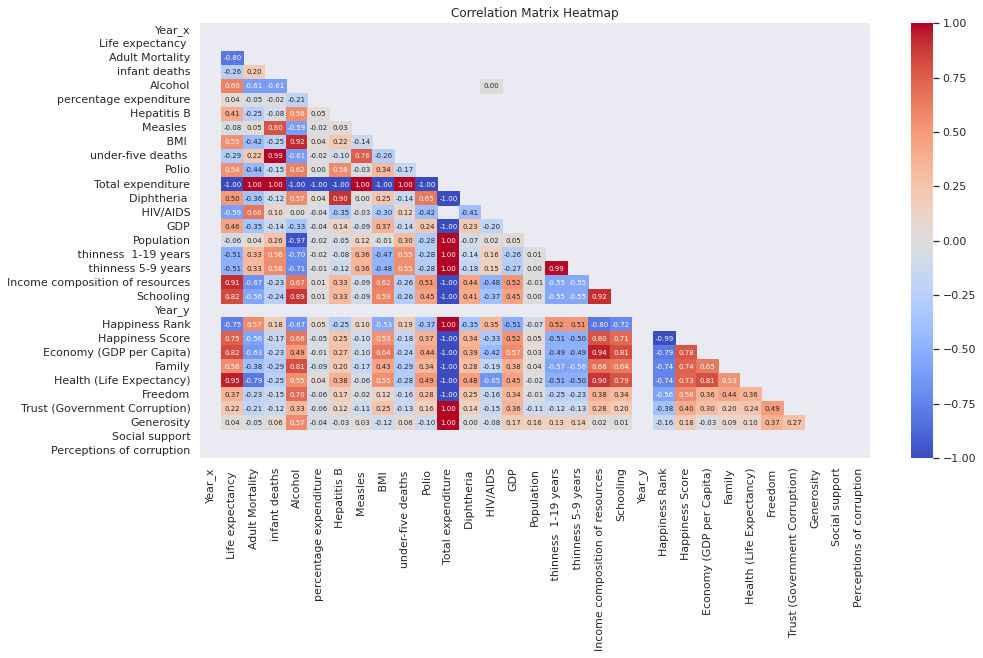

In [57]:
# Correlation Matrix Heatmap for the above correlation analysis
mask = np.triu(df_corr)
plt.figure(figsize=(15,8))
sns.heatmap(df_corr, annot=True, annot_kws={"fontsize":7}, fmt='.2f', cmap='coolwarm', mask=mask)
plt.title('Correlation Matrix Heatmap')
plt.show()